# Note:
- This notebook file may contain methods or algorithms that are NOT covered by the teaching content of BT4222 and hence will not be assessed in your midterm exam.
- It serves to increase your exposure in depth and breath to the practical methods in addressing the specific project topic. We believe it will be helpful for your current project and also your future internship endeavors.

# BT4222 Large Langauge Models Project


---


<!-- <center>
<img src="https://github.com/huggingface/blog/blob/main/assets/96_hf_bitsandbytes_integration/Thumbnail_blue.png?raw=true" alt="drawing" width="700" class="center"/>
</center> -->


Natural language processing (NLP) models have revolutionized the way we interact with technology and access information. One of the most remarkable breakthroughs in NLP is the development of large language models (LLMs) like GPT-4, which has demonstrated astonishing capabilities in generating human-like text.

Regardless of your expertise level in NLP, this project offers a step-by-step journey into the world of LLMs, guiding you through the process of adapting the model to your unique dataset. By the end, you'll have crafted a model that can cater to the needs of your target audience. Through this hands-on project, you will have the unique opportunity to harness the power of LLMs and mold it according to your specific use case. Let's embark together on the adventure of building your own model that stands at the forefront of advanced language processing technology!




In this project, we will learn how to load a large model (`llama-7B`) and train it using Google Colab and PEFT library from Hugging Face.


Important!
Training LLMs is faster using GPUs than CPUs.

Make sure GPU is selected before running the rest of the code:

Runtime -> Change runtime type -> Hardware Accelerator: GPU

The following code check if GPU is available.


In [ ]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
else:
    print("No GPU available.")

GPU: Tesla T4


## Preparation
First, install the necessary packages for training LLMs. This may take some time, but it only needs to install once for each runtime.

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece==0.1.99
!pip install -q -U datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In order to save the trained model weights to google drive for future use, we need to enable access to google drive and mount googe drive to colab.


You can use the drive module from google.colab to mount your entire Google Drive to Colab by:

1. Executing the below code

2. Choose the Google account whose Drive you want to mount

3. Allow Google Drive Stream access to your Google Account

Once the Drive is mounted, you will get the message `Mounted at /content/gdrive`, and you will be able to browse through the contents of your Drive from the file-explorer pane. Now you can interact with your Google Drive as if it was a folder in your Colab environment. Any changes to this folder will reflect directly in your Google Drive. You can read the files in your Google Drive as any other file.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Part 1. Finetuning

Let's load a popular pretrained language model: LLaMA-7B!

Using pre-trained models in NLP offers advantages of time and resource efficiency, better performance, and generalization. These models are already trained on large datasets, allowing transfer learning to specific tasks.

Feel free to try other pretrained language models.




In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaForCausalLM, LlamaTokenizer, BloomForCausalLM, BloomTokenizerFast, OPTForCausalLM
from datasets import load_dataset

model_name = "decapoda-research/llama-7b-hf"
# model_name = "EleutherAI/gpt-neox-20b"
# model_name = "bigscience/bloomz-7b1-mt"
# model_name = "EleutherAI/gpt-j-6B"
# model_name = "facebook/opt-6.7b"
# model_name = "facebook/opt-350m"
# model_name = "EleutherAI/gpt-neo-2.7B"
# model_name = "databricks/dolly-v2-7b"
# model_name = "EleutherAI/pythia-12b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Change the corresponding model and tokenizer when trying other models.
model = LlamaForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map={"":0})
tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')
tokenizer.pad_token_id = 0

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565, and set the legacy attribute accordingly.


Then we have to apply some preprocessing to the model to prepare it for training. We use the `prepare_model_for_kbit_training` method from PEFT.

QLoRA (Dettmers et al., 2023) proposes optimization
methods via quantized low rank fine tuning. Innovations of QLoRA include a 4-bit data type: NormalFloat4, which optimizes information efficiency
for normally distributed data (e.g. weights) based
on information theory. Apart from that, the paper uses Paged Optimizers (partial optimizer state
stored on CPU rather than GPU) to manage memory spikes, like when processing mini batches with
long sequence lengths. Experiment results show
that fine-tuning using QLoRA reaches 99.3% of
the performance of ChatGPT!

Here is an illustration of LoRA technique (extracted from https://abvijaykumar.medium.com/fine-tuning-llm-parameter-efficient-fine-tuning-peft-lora-qlora-part-1-571a472612c4)

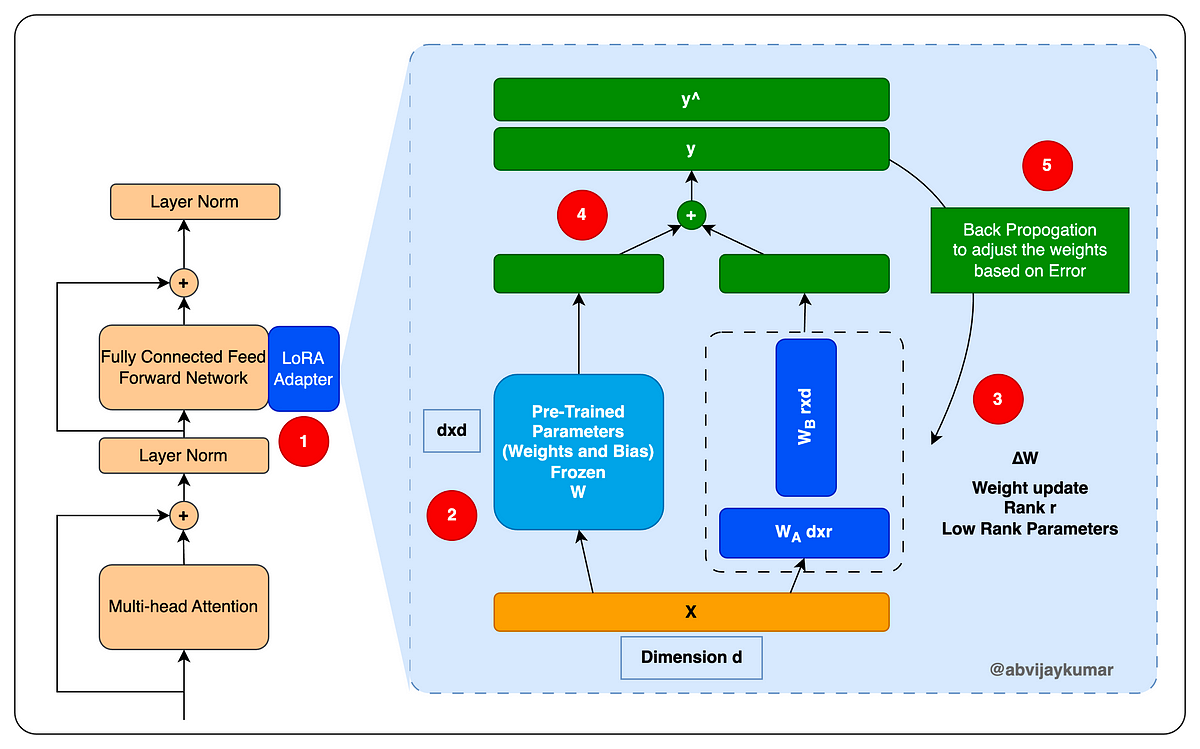

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# for some models, target_modules = ['query_key_value']
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "v_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4194304 || all params: 3504607232 || trainable%: 0.11967971650867153


## Dataset

Let's load a popular dataset, `databricks/databricks-dolly-15k`, to finetune our model on general question answering.


`databricks-dolly-15k` is an open source dataset of instruction-following records generated by thousands of Databricks employees in several of the behavioral categories outlined in the InstructGPT paper, including brainstorming, classification, closed QA, generation, information extraction, open QA, and summarization.


Please take a look at the dataset https://huggingface.co/datasets/databricks/databricks-dolly-15k before proceeding.

We use two fields from the dataset to finetune our model:
1) `instruction`: user input, and
2) `response`: expected output from our model

In [ ]:
from datasets import load_dataset
data_path = "databricks/databricks-dolly-15k" # It automatically downloads data from huggingface website.

cutoff_len = 512
train_on_inputs = False

if data_path.endswith(".json") or data_path.endswith(".jsonl"):
    data = load_dataset("json", data_files=data_path)
else:
    data = load_dataset(data_path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from typing import Union

def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result


def generate_prompt(
    instruction: str,
    label: Union[None, str] = None,
) -> str:

    result = f"Question:\n{instruction}\nAnswer:\n"

    if label:
        result = f"{result}{label}"

    return result


def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(
        data_point["instruction"],
        data_point["response"],
    )
    tokenized_full_prompt = tokenize(full_prompt)
    if not train_on_inputs:
        user_prompt = generate_prompt(
            data_point["instruction"]
        )
        tokenized_user_prompt = tokenize(
            user_prompt, add_eos_token=False
        )
        user_prompt_len = len(tokenized_user_prompt["input_ids"]) - 1

        tokenized_full_prompt["labels"] = [
            -100
        ] * user_prompt_len + tokenized_full_prompt["labels"][
            user_prompt_len:
        ]
    return tokenized_full_prompt

# For the purpose of demonstration, we just finetune the model using 1000 instances.
train_split = data["train"].train_test_split(train_size = 1000)
train_data = train_split["train"].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Training

The cell below fine-tunes the model and saves the QLoRA adapter weights.

The `Trainer` class simplifies the training process for transformer models and provides a unified API to manage training loops, batching, optimization, etc.

Here's a brief explanation of the training hyperparameters used in the code:

1. `per_device_train_batch_size`:
The number of training samples (data points) processed in one forward and backward pass for each GPU (device) during training. In this case, it is set to 1, meaning each training batch contains a single sample. A lower value may be used for very large models or datasets that don't fit into GPU memory.
2. `gradient_accumulation_steps`:
The number of backward passes (gradients accumulation) that are performed before updating the model's parameters. This effectively simulates using larger batch sizes without the need for additional GPU memory. In this case, the gradients are accumulated over 4 steps before updating the model's parameters.
3. `warmup_steps`:
The number of optimization steps during which the learning rate increases gradually from 0 to the specified learning_rate. Warmup helps stabilize training at the beginning and is often used with large models.
4. `save_strategy` and `save_steps`:
The strategy and frequency of saving model checkpoints during training.
5. `num_train_epochs`:
The total number of training epochs (passes through the entire training dataset) during training.
6. `learning_rate`:
The learning rate for the optimization algorithm used during training.
7. `fp16`:
A boolean flag indicating whether to use mixed-precision training (Half-precision floating-point format - float16) for faster training on compatible hardware. Setting fp16=True enables mixed-precision training.
8. `logging_steps`:
The frequency (in optimization steps) at which logs and metrics are displayed during training. In this case, logs are displayed every optimization step.
9. `output_dir`:
The directory where the model checkpoints are stored during training.
10. `optim`:
The optimization algorithm used during training. In this case, "paged_adamw_8bit" is used for QloRA.


Keep in mind that hyperparameters like learning rate, batch size, etc. may significantly impact the training process and should be carefully tuned for the specific model and dataset to achieve optimal performance. For more detailed explanation of the `Trainer` parameters, you may refer to https://huggingface.co/docs/transformers/main_classes/trainer


If you encounter 'OutOfMemoryError' error, try to reduce `per_device_train_batch_size` and `gradient_accumulation_steps`.


The training may take some time, depending on the size of your dataset. Please take note that Google Colab sessions have a time limit of 12 hours, after which they will automatically shut down.

In [ ]:
import transformers

output_dir = "/content/gdrive/MyDrive/weights"

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        warmup_steps=50,
        save_strategy="steps",
        save_steps=50,
        num_train_epochs=1,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir=output_dir,
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForSeq2Seq(
            tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
        ),
)

model.config.use_cache = False

trainer.train()

model.save_pretrained(output_dir)

Step,Training Loss
1,1.396500
2,1.559800
3,1.533900
4,1.626200
5,1.238200
6,1.706600
7,1.523300
8,1.636600
9,1.546100
10,1.226900


## Part 2. Inference

Note that after finetuning the model and saving the weights, you can run part 2 directly without running part 1. Remember to run the preparation section to install packages after restarting runtime.

In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM, LlamaTokenizer, StoppingCriteria, StoppingCriteriaList, TextIteratorStreamer
from transformers import BloomForCausalLM, BloomTokenizerFast, OPTForCausalLM
from transformers import BitsAndBytesConfig, GenerationConfig

First, we load the pretrained language model and the saved qlora adapter weights.

In [ ]:
model_name = "decapoda-research/llama-7b-hf"

# the directory of your saved model weights
adapters_name = "/content/gdrive/MyDrive/weights"

model = LlamaForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map={"": 0}
)

tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')

model = PeftModel.from_pretrained(model, adapters_name, device_map={"": 0}, torch_dtype=torch.bfloat16)

model.eval()

print(f"Successfully loaded the model {model_name} with adapter weights into memory")

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565, and set the legacy attribute accordingly.


Successfully loaded the model decapoda-research/llama-7b-hf with adapter weights into memory


In [ ]:
from typing import Union

def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result


def generate_prompt(
    instruction: str,
    label: Union[None, str] = None,
) -> str:

    result = f"Question:\n{instruction}\nAnswer:\n"

    if label:
        result = f"{result}{label}"

    return result


def get_response(output: str) -> str:
    return output.split("Answer:\n")[-1].strip()


def evaluate(
    instruction,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=256,
    stream_output=True,
    **kwargs,
):
    prompt = generate_prompt(instruction)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to("cuda")
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )

    generate_params = {
        "input_ids": input_ids,
        "generation_config": generation_config,
        "return_dict_in_generate": True,
        "output_scores": True,
        "max_new_tokens": max_new_tokens,
    }

    # Without streaming
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True).strip()
    return get_response(output)


Now, we can generate some text using our finetuned model.

In [ ]:
question = "Where is the National University of Singapore?"

output = evaluate(question)
print(output)

The National University of Singapore is located in Singapore.


To validate the success of finetuning, you can compare the outputs between your finetuned model and the original pretrained model. The code below generates text from the original pretrained model before the finetuning process.
```
model = "decapoda-research/llama-7b-hf"
tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')
inputs = tokenizer(question, return_tensors="pt").to("cuda:0")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
```

Finally, let's build a simple Web UI using gradio!

In [ ]:
!pip install -q -U gradio

In [ ]:
import gradio as gr

gr.Interface(
    fn=evaluate,
    inputs=[
        gr.components.Textbox(
            lines=1,
            label="Question",
            placeholder="Where is the National University of Singapore?",
        ),
        gr.components.Slider(
            minimum=0, maximum=1, value=0.1, label="Temperature"
        ),
        gr.components.Slider(
            minimum=0, maximum=1, value=0.75, label="Top p"
        ),
        gr.components.Slider(
            minimum=0, maximum=100, step=1, value=40, label="Top k"
        ),
        gr.components.Slider(
            minimum=1, maximum=4, step=1, value=4, label="Beams"
        ),
        gr.components.Slider(
            minimum=1, maximum=1024, step=1, value=512, label="Max tokens"
        ),
    ],
    outputs=[
        gr.inputs.Textbox(
            lines=5,
            label="Answer",
        )
    ],
    title="BT4222 LLM Project Demo",
    description="BT4222 Large Language Model Project",  # noqa: E501
).queue().launch(server_name="0.0.0.0", share=True)

<ipython-input-22-1129034826a2>:28: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.inputs.Textbox(
<ipython-input-22-1129034826a2>:28: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  gr.inputs.Textbox(
<ipython-input-22-1129034826a2>:28: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  gr.inputs.Textbox(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://650ba56a9cdbb670f6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Accessment Criteria
The assessment will evaluate students' creativity in constructing a novel dataset and effectively utilizing it for fine-tuning the model to address real-life challenges. Students are encouraged to engage with TAs for feedback before embarking on extensive data collection.

1. Students demonstrate minimal initiative by relying on existing open-source datasets for fine-tuning, without engaging in dataset creation.

2. Students design a dataset that closely resembles available open-source datasets, showcasing minor improvements in quality or diversity.

3. Students propose a dataset that exhibits some advancements over existing open-source datasets.

4. Despite the presence of existing open-source datasets within the same domain, students present a dataset that substantially surpasses these existing datasets in terms of either quality or quantity.

5. Students take the initiative to establish a completely new dataset in specific domain and effectively fine-tune the model to achieve the desired proficiency.